# DS-SF-23 | Codealong and Lab 13 | Natural Language Processing and Text Classification | Answer Key

# Codealong - Text Processing with `sklearn`

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import feature_extraction, ensemble, cross_validation, metrics

pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline
plt.style.use('ggplot')

The data is about sentiments on Amazon reviews.

In [2]:
reviews = []
sentiments = []

with open(os.path.join('..', 'datasets', 'amazon-reviews.txt')) as f:
    for line in f.readlines():
        line = line.strip('\n')
        review, sentiment = line.split('\t')
        sentiment = np.nan if sentiment == '' else int(sentiment)

        reviews.append(review)
        sentiments.append(sentiment)

df = pd.DataFrame({'review': reviews, 'sentiment': sentiments})

In [3]:
df.head()

,review,sentiment
0,I try not to adjust the volume setting to avoi...,NaN
1,So there is no way for me to plug it in here i...,0
2,"Good case, Excellent value.",1
3,I thought Motorola made reliable products!.,NaN
4,Battery for Motorola Razr.,NaN


In [4]:
df.dropna(inplace = True) # Let's drop NaNs

In [5]:
df.head()

,review,sentiment
1,So there is no way for me to plug it in here i...,0
2,"Good case, Excellent value.",1
5,Great for the jawbone.,1
10,Tied to charger for conversations lasting more...,0
11,The mic is great.,1


In [6]:
X = df.review
y = df.sentiment

## Train/test sets

In [7]:
train_X, test_X, train_y, test_y = cross_validation.train_test_split(X, y, test_size = 0.4)

In [8]:
train_X

2033    The nokia CA-42 USB cable did not work with my...
1681                              Don't buy this product.
1814    It does everything the description said it would.
1630                     horrible, had to switch 3 times.
1342    Overall, I am psyched to have a phone which ha...
                              ...                        
1995                    I could not recommend these more.
1974                                 Battery is terrible.
2541                           Last time buying from you.
66                                   Doesn't hold charge.
2218    I bought this battery with a coupon from Amazo...
Name: review, dtype: object

## `CountVectorizer`

`CountVectorizer` converts a collection of text into a matrix of features.  Each row will be a sample (an article or piece of text) and each column will be a text feature (usually a count or binary feature per word).

`CountVectorizer` takes a column of text and creates a new dataset.  It generates a feature for every word in all of the pieces of text.

CAUTION: Using all of the words can be useful, but we may need to use regularization to avoid overfitting.  Otherwise, rare words may cause the model to overfit and not generalize.

(And check http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html as needed)

In [9]:
# Instantiate a new CountVectorizer

# Stopwords are non-content words.  (e.g. 'to', 'the', and 'it')
# They aren’t helpful for prediction, so we remove them.

vectorizer = feature_extraction.text.CountVectorizer(stop_words = 'english')

In [10]:
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Vectorizers are like other models in `sklearn`:
- We create a vectorizer object with the parameters of our feature space
- We fit a vectorizer to learn the vocabulary
- We transform a set of text into that feature space

Note: there is a distinction between fit and transform:
- We fit from our training set.  This is part of the model building process, so we don't look at our test set
- We transform our test set using our model fit on the training set

In [11]:
# We use `fit` to learn the vocabulary of the reviews

vectorizer.fit(train_X)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [12]:
# The bag-of-words

vectorizer.get_feature_names()

['10',
 '11',
 '12',
 '15',
 '18',
 '2005',
 '2160',
 '2mp',
 '350',
 '3o',
 '42',
 '44',
 '45',
 '50',
 '510',
 '8525',
 '8530',
 'ability',
 'able',
 'abound',
 'absolutely',
 'ac',
 'accept',
 'acceptable',
 'access',
 'accessoryone',
 'activated',
 'actually',
 'adapters',
 'addition',
 'additional',
 'address',
 'adhesive',
 'adorable',
 'advertised',
 'advise',
 'aggravating',
 'ago',
 'alarm',
 'allot',
 'allowing',
 'allows',
 'alot',
 'aluminum',
 'amazed',
 'amazing',
 'amazon',
 'amp',
 'ample',
 'angle',
 'answer',
 'antena',
 'anti',
 'apart',
 'appealing',
 'appearance',
 'appears',
 'appointments',
 'area',
 'armband',
 'arrival',
 'arrived',
 'asia',
 'att',
 'attacked',
 'attractive',
 'audio',
 'authentic',
 'auto',
 'avoid',
 'avoiding',
 'away',
 'awesome',
 'awful',
 'awkward',
 'awsome',
 'background',
 'backlight',
 'bad',
 'bar',
 'barely',
 'bargain',
 'bars',
 'basically',
 'batteries',
 'battery',
 'beats',
 'beautiful',
 'beeping',
 'believe',
 'bells',
 'be

In [13]:
# We use `tranform` to generate the sample X word matrix - one column per feature (here, a word)

train_X_transformed = vectorizer.transform(train_X)
test_X_transformed = vectorizer.transform(test_X)

In [14]:
train_X_transformed

<600x1200 sparse matrix of type '<class 'numpy.int64'>'
	with 2859 stored elements in Compressed Sparse Row format>

While dense matrices store every entry in the matrix, sparse matrices only store the nonzero entries.  Sparse matrices don't have a lot of extra features, and some algorithms may not work for them so you use them when you need to work with matrices that would be too big for the computer to handle them, but they are mostly zero, so they compress easily.  You can convert from sparse matrices to dense matrices with `.todense()`

In [15]:
train_X_transformed.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## Random Forest

We can now build a random forest model to predict "sentiment".

In [16]:
model = ensemble.RandomForestClassifier(n_estimators = 5)

cross_validation.cross_val_score(model, train_X_transformed, train_y, scoring = 'roc_auc')

array([ 0.7890099 ,  0.8369    ,  0.80257576])

In [17]:
model.fit(train_X_transformed, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
model.score(train_X_transformed, train_y)

0.96166666666666667

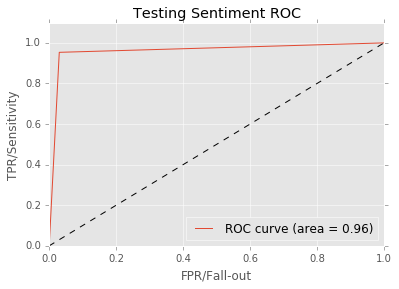

In [19]:
train_y_hat = model.predict(train_X_transformed)

fpr, tpr, thresholds = metrics.roc_curve(train_y, train_y_hat)

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([.0, 1.])
plt.ylim([.0, 1.1])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title('Testing Sentiment ROC')
plt.legend(loc = 'lower right')
plt.show()

In [20]:
model.score(test_X_transformed, test_y)

0.73499999999999999

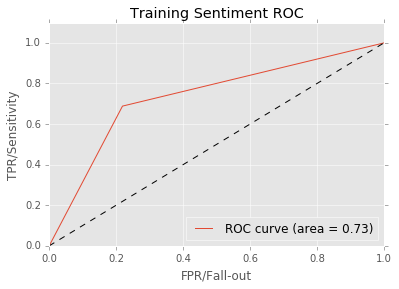

In [21]:
test_y_hat = model.predict(test_X_transformed)

fpr, tpr, thresholds = metrics.roc_curve(test_y, test_y_hat)

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([.0, 1.])
plt.ylim([.0, 1.1])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title('Training Sentiment ROC')
plt.legend(loc = 'lower right')
plt.show()

# Lab - TF-IDF

Directions: Redo the analysis above with `TfidfVectorizer` instead of `CountVectorizer`.  What do you get?

(Check http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html as needed)

In [22]:
vectorizer = feature_extraction.text.TfidfVectorizer(stop_words = 'english')

In [23]:
vectorizer.fit(train_X)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [24]:
train_X_transformed = vectorizer.transform(train_X)

In [25]:
test_X_transformed = vectorizer.transform(test_X)

In [26]:
model = ensemble.RandomForestClassifier(n_estimators = 5)

cross_validation.cross_val_score(model, train_X_transformed, train_y, scoring = 'roc_auc')

array([ 0.79326733,  0.7964    ,  0.81090909])

In [27]:
model.fit(train_X_transformed, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
model.score(train_X_transformed, train_y)

0.96666666666666667

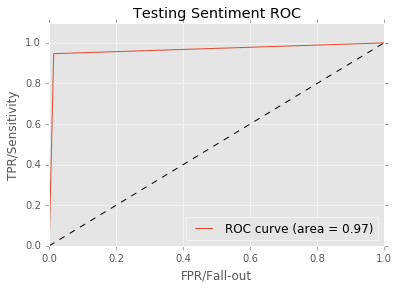

In [29]:
train_y_hat = model.predict(train_X_transformed)

fpr, tpr, thresholds = metrics.roc_curve(train_y, train_y_hat)

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([.0, 1.])
plt.ylim([.0, 1.1])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title('Testing Sentiment ROC')
plt.legend(loc = 'lower right')
plt.show()

In [30]:
model.score(test_X_transformed, test_y)

0.71250000000000002

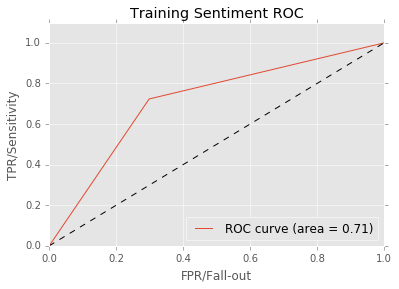

In [31]:
test_y_hat = model.predict(test_X_transformed)

fpr, tpr, thresholds = metrics.roc_curve(test_y, test_y_hat)

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([.0, 1.])
plt.ylim([.0, 1.1])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title('Training Sentiment ROC')
plt.legend(loc = 'lower right')
plt.show()